# Mini-Challenge #2: predicting the book rating according to a review
## Team: White Tea 
### Members: Yang Tian (Matr.-Nr.: 5074001, FU Berlin), Yu Fan (Matr.-Nr.: 5064892, FU Berlin)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

plt.style.use('ggplot')
%matplotlib inline

In [0]:
# loading training and test data
from google.colab import drive
drive.mount('/content/gdrive')
tr_PATH = './gdrive/My Drive/DL/Projects/Book Rating/MC2.csv' # training set
ts_PATH = './gdrive/My Drive/DL/Projects/Book Rating/MC2test.csv' # test set

tr = pd.read_csv(tr_PATH).set_index('Unnamed: 0')
ts = pd.read_csv(ts_PATH).set_index('Unnamed: 0')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 1. Overview of the dataset

In [0]:
tr.info()
tr.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099209 entries, 1 to 1099209
Data columns (total 8 columns):
product_id           1099209 non-null object
product_title        1099209 non-null object
star_rating          1099209 non-null int64
helpful_votes        1099209 non-null int64
total_votes          1099209 non-null int64
verified_purchase    1099209 non-null object
review_headline      1099196 non-null object
review_body          1099207 non-null object
dtypes: int64(3), object(5)
memory usage: 75.5+ MB


,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
Unnamed: 0,,,,,,,,
1,0983797706,Igniting Your True Purpose and Passion: A Busi...,5,0,0,N,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...
2,1423151283,The Duckling Gets a Cookie!? (Pigeon),5,0,0,N,Loved it!,My twins are 3 and they love the pigeon books!...
3,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,4,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."
4,0393057941,The Bread Bible,5,0,0,N,Great book for beginners,I disagree with those reviews that say this is...
5,1608322858,Do It Well. Make It Fun.: The Key to Success i...,3,2,2,N,Left me wanting more,"Reading this book, I hoped to find more about ..."
6,B001FVQAPW,Myth and Christianity: An Inquiry into the Pos...,5,3,3,N,"A ""SEMI-DIALOGUE"" BETWEEN TWO TOWERING 20TH CE...",Rudolf Bultmann (1884-1976) was a German theol...
7,0307157857,Richard Scarry's Cars and Trucks and Things Th...,5,0,0,N,Best Toddler Boy Picture Book,My son has adored this book since he could sit...
8,0670022969,American Nations: A History of the Eleven Riva...,5,370,388,Y,Like scales falling from my eyes,Colin Woodard has written the story of North A...
9,193260393X,A Caregiver's Guide to Lewy Body Dementia,2,1,4,N,Disappointed and not worth the money,"I was overall, very disappointed with this boo..."


In [0]:
# Checking the Na/NaN values in the data frame

def findNaN(df, sum=True):
  if sum==True:
    return np.sum(df.isnull())
  else:
    return np.where(df.isnull())
  
print(tr.isnull().sum(axis=0), '\n')

print("Total number of records: ", tr.shape[0])
print("Number of records with unique product ID: ", np.unique(tr["product_id"]).shape[0], "\n")
print("Number of Missings in the Dataset\n")
print("Number of missings in product ID: ", findNaN(tr.product_id))
print("Number of missings in Headline: ", findNaN(tr.review_headline))
print("Number of missings in Body: ", findNaN(tr.review_body), "\n")
print("Index of missings in the Dataset\n")
print("Index of missings in the review headline: \n", findNaN(tr.review_headline, False))
print("Index of missings in the review body: \n", findNaN(tr.review_body, False))

product_id            0
product_title         0
star_rating           0
helpful_votes         0
total_votes           0
verified_purchase     0
review_headline      13
review_body           2
dtype: int64 

Total number of records:  1099209
Number of records with unique product ID:  540434 

Number of Missings in the Dataset

Number of missings in product ID:  0
Number of missings in Headline:  13
Number of missings in Body:  2 

Index of missings in the Dataset

Index of missings in the review headline: 
 (array([  40304,  180433,  573567,  646587,  903807,  922540,  958151,
        995901,  998520, 1005610, 1046110, 1049675, 1096752]),)
Index of missings in the review body: 
 (array([ 716204, 1077127]),)


#### Since there is no overlap between NaNs in the review body and those in the review headline, it will not hurt us if we combine these two parts together before conducting word embedding. Otherwise, rows with NaNs can be deleted. 

#### Let's have a look at our target variable - the star rating. In total, there are 5 levels of the ratings. In the following model we will create, multiclass classification should be the right strategy and 5 classes should be predicted. Specifically, the dataset is imbalanced, where the level of "5 star rating" occupies about 61%.

5    675734
4    208329
3     91574
1     69240
2     54332
Name: star_rating, dtype: int64 

Percentage of five-star ratings:  0.6147456944038849
Percentage of positive ratings:  0.8042719810336342
Percentage of negative ratings:  0.11241902131441792 



Text(0, 0.5, 'count')

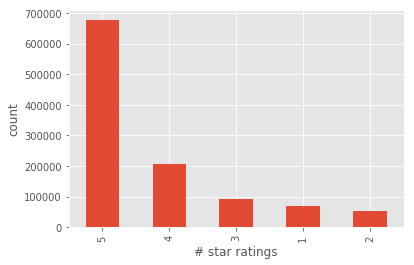

In [0]:
# Checking the rating distribution

v = pd.Series(tr['star_rating']).value_counts()
print(v, "\n")

print("Percentage of five-star ratings: ", v.iloc[0] / v.sum())
print("Percentage of positive ratings: ", v.iloc[:2].sum() / v.sum())
print("Percentage of negative ratings: ", v.iloc[3:].sum() / v.sum(), "\n")

v.plot(kind='bar')
plt.xlabel('# star ratings')
plt.ylabel('count')

031606792X    822
0964729237    648
0316015849    581
0545010225    547
0399155341    473
0805093079    433
0316031844    426
0143038257    417
1582701709    399
0439023513    383
0143038419    380
0385504225    375
1416562850    372
1565125606    357
0307454541    341
0439023521    340
0849946158    327
1594480001    290
0316160202    283
1892112000    279
030746363X    268
1400064163    259
0553801473    244
0762424931    237
074324754X    237
0439023491    237
1439173249    228
0439023483    226
0061939897    224
015602943X    221
Name: product_id, dtype: int64 

The volume of top-100 best sellers ranges from 822 to 111. 



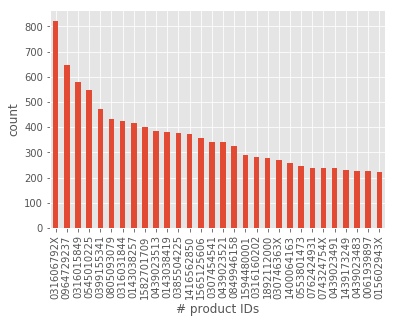

In [0]:
ID = pd.Series(tr['product_id']).value_counts()
ID.iloc[:30].plot(kind='bar')
plt.xlabel('# product IDs')
plt.ylabel('count')

print(ID.iloc[:30], '\n')
print("The volume of top-100 best sellers ranges from {} to {}.".format(ID.iloc[0], ID.iloc[100]), '\n')

#### Since variables including helpful / total votes take place after a review is made, it hardly makes sense to use such variables in the predictive model. However, a first exploration might help us better understand our dataset.

0     325796
1     219490
2     134844
3      89246
4      61159
5      44587
6      33889
7      26028
8      20402
9      16568
10     13874
11     11720
12      9789
13      8476
14      7243
15      6433
16      5415
17      4750
18      4230
19      3850
20      3442
21      2965
22      2770
23      2592
24      2295
25      2026
26      1952
27      1791
28      1575
29      1533
Name: helpful_votes, dtype: int64 

Most reviews, i.e., 75.6 percent of them end up with less than 5 helpful votes. 



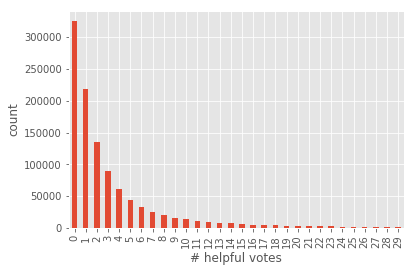

In [0]:
hv = pd.Series(tr['helpful_votes']).value_counts()
hv.iloc[:30].plot(kind='bar')
plt.xlabel('# helpful votes')
plt.ylabel('count')

print(hv.iloc[:30], '\n')
print("Most reviews, i.e., {:.{prec}f} percent of them end up with less than 5 helpful votes.".format(hv.iloc[:5].sum() / hv.sum() * 100, prec=1), '\n')

0     244560
1     188252
2     137370
3      97229
4      72455
5      54591
6      41680
7      33119
8      26725
9      21555
10     18245
11     15174
12     13232
13     11251
14      9750
15      8751
16      7497
17      6784
18      5943
19      5387
20      4854
21      4440
22      3920
23      3696
24      3355
25      2994
26      2863
27      2630
28      2400
29      2238
Name: total_votes, dtype: int64 

Most reviews, i.e., 67.3 percent of them end up with less than 5 total votes. 



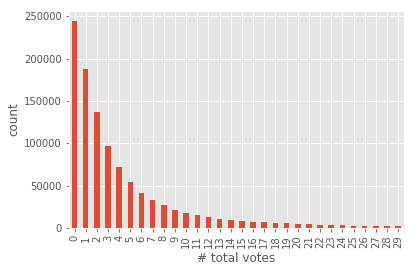

In [0]:
tv = pd.Series(tr['total_votes']).value_counts()
tv.iloc[:30].plot(kind='bar')
plt.xlabel('# total votes')
plt.ylabel('count')

print(tv.iloc[:30], '\n')
print("Most reviews, i.e., {:.{prec}f} percent of them end up with less than 5 total votes.".format(tv.iloc[:5].sum() / tv.sum() * 100, prec=1), '\n')

### 2. Data Preprocessing

#### Before the model is established, we need to preprocess the data and to make sure they are the right form as inputs feeded to the neural network.

In [0]:
tr = tr.dropna()

tr.star_rating = tr.star_rating.astype('category')

tr.verified_purchase = tr.verified_purchase.astype('category')
ts.verified_purchase = ts.verified_purchase.astype('category')

# concatenate review headline and review body to a new variable "review"
tr['review'] = tr['review_headline'].str.cat(tr[['review_body']], sep='. ')
ts['review'] = ts['review_headline'].str.cat(ts[['review_body']], sep='. ')

X = tr['review'].astype(str)
y = tr['star_rating']

In [0]:
print('Review: ', X.values[5])
print('Rating: ', y.iloc[5])

Review:  A "SEMI-DIALOGUE" BETWEEN TWO TOWERING 20TH CENTURY INTELLECTUAL FIGURES. Rudolf Bultmann (1884-1976) was a German theologian and professor of New Testament at the University of Marburg. He was the author of many influential books, such as [[ASIN:1565630416 The History of the Synoptic Tradition]], [[ASIN:0684143909 Jesus and the Word]], etc. Karl Jaspers (1883-1969) was a German psychiatrist and existentialist philosopher, who wrote many important books such as [[ASIN:B000S6THQE Reasons and Existenz]][[ASIN:0812210107 Philosophy of Existence]], [[ASIN:0300097352 Way to Wisdom: An Introduction to Philosophy]], [[ASIN:B0007EW69C Man in the modern age]], [[ASIN:0226394859 Future of Mankind]], etc.<br /><br />The translator notes, \\"The essay 'Myth and Religion' by Dr. Jaspers ... was later published (in 1953)... Bultmann's reply first appeared (in 1954)... Dr. Jaspers' rejoinder was first published in an open letter...\\"<br /><br />Jaspers argues, \\"It we forget that myth is a

#### There are plenty of ways to preprocess, i.e. to tokenize the text data. We will firstly use the convienient one Keras provides. 
#### The function Tokenizer() takes care not only of splitting, lowercasing and stripping special characters, but also help to keep N most common words in the data set, preventing too large input vector spaces.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 16000 # We will keep only the 16k most common words

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(X) 
sequences = tokenizer.texts_to_sequences(X) # list: string - numbers(indices)
word_index = tokenizer.word_index # dict: word - number(index)

print('Found {} unique tokens.'.format(len(word_index)))

# word_index is a dictionary that maps the word to its corresponding index in the vocabulary:
w1 = "cat"
print("Index of", w1, "in the vocabulary: ", word_index[w1])

# sequences is a tuple of lists denoting the corresponding indices of the words in each string (review):
print('The indices of words in the number', sequences.index(sequences[4]),'review:', sequences[4])

Using TensorFlow backend.


Found 726132 unique tokens.
Index of cat in the vocabulary:  1580
The indices of words in the number 4 review: [305, 52, 921, 42, 85, 9, 10, 6, 2656, 4, 111, 42, 35, 768, 8, 66, 8, 524, 20, 814, 41, 6, 130, 17, 35, 820, 6469, 8, 1, 929, 9289, 112, 89, 52, 463, 6, 23, 276, 36, 34, 399, 307, 1, 91, 3, 5542, 99, 6518, 63, 34, 175, 4, 78, 11, 2, 81, 1986, 1275, 254, 384, 7, 503, 5, 2096, 3340, 4, 249, 5, 51, 66, 20, 61, 11, 322, 4, 403, 56, 403, 425, 42, 4, 66, 84, 62, 4940, 13, 13, 2, 317, 138, 9, 10, 305, 52, 648, 5, 229, 305, 140, 6, 110, 41, 11, 322, 140, 4, 7, 9, 174, 5, 166, 3, 4029, 12, 6, 2, 74, 227, 358, 112, 783, 15, 41, 27, 300, 16, 1, 554, 2897, 3, 66, 4940, 5101, 88, 249, 5, 254, 36, 34, 74, 227, 23, 1983, 2869, 4, 78, 203, 176, 14, 376, 1, 1019, 49, 3, 1, 185, 40, 3780, 632, 582, 349, 6, 3780, 4, 1, 1829, 2, 268, 2836, 1, 1019, 1387, 3, 5, 443, 840, 40, 806, 282, 33, 2999, 13, 13, 38, 43, 18, 21, 358, 207, 14, 5, 354, 26, 19, 53, 4, 105, 1, 91, 3, 1, 6706, 1424, 6, 144, 78, 1

In [0]:
# Furthermore, we need to pad the sequences so that their lengths are the same and do not exceed a specific maximum length.
maxlen = 256
X = pad_sequences(sequences, maxlen=maxlen)

# Transform the target "rating" to one-hot encoding
from sklearn.preprocessing import OneHotEncoder

y = np.asarray(y)
onehot_encoder = OneHotEncoder(sparse=False)
encoded = y.reshape(len(y), 1)
Y = onehot_encoder.fit_transform(encoded)

print('Shape of data tensor: ', X.shape)
print('Shape of label tensor: ', Y.shape)

Shape of data tensor:  (1099194, 256)
Shape of label tensor:  (1099194, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### 3. Word Embedding using pre-trained GloVe

#### The next step would be associating words with vectors, which the neural network expects as its input. The use of word embeddings, which are learnt from data and contain more information as well as lower dimensions than one-hot word vectors, is a powerful way to do that. One can either use the data to learn a task-specific word embeddings, or load pre-trained word embeddings that have been precomputed. In this task, we will load pre-trained word embeddings. GloVe pre-trained word embeddings with 200 dimensions are chosen as our try.

In [0]:
# Map words with their word representations from GloVe pre-trained word embeddings
embeddings_index = {}
gl_PATH = './gdrive/My Drive/DL/NLP/glove.6B.200d.txt' # pretrained GloVe
f = open(gl_PATH)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

# Create a embedding matrix for the Embedding() layer in the model, with the shape of (max_words, embedding_dim).
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items(): 
  if i < max_words:
    embedding_vector = embeddings_index.get(word) # Convert word of index i in the word_index to its word vector with 100 dimensions
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [0]:
# Split data into training, validation and test data sets.
from sklearn.model_selection import train_test_split

# train : val : test = 98 : 1 : 1
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.02, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1)

### 4. Building Models and Training 

### Model 0 (Baseline Model): Pre-trained 200D GloVe embedding layer with fixed weights + 1D convolutional layer + 2 GRUs, with layer normalization

In [0]:
!pip install keras-layer-normalization

  Stored in directory: /root/.cache/pip/wheels/c3/9b/9e/f4072915f660e90bb3638332276f4de80476f3afcb5d010d6f
Successfully built keras-layer-normalization


#### Study finds that layer normalization works better for RNN architectures, since batch normalization requires sufficient amount of data points with in each batch in order to get a reliable estimate of the mean and the variance of the data. Instead, layer normalization can be Implemented on each single data point. Ba et al. (2016) find that LN accelerates the training speed of RNN models.

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Dropout, GRU, Conv1D, MaxPooling1D, BatchNormalization, Activation, concatenate

from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_layer_normalization import LayerNormalization

inputs = Input(shape=(256,), dtype='int32')
x = Embedding(max_words, embedding_dim, input_length=maxlen)(inputs)

x = Conv1D(128, 
           7,
           kernel_regularizer=l2(0.01),
           kernel_initializer=keras.initializers.he_normal(seed=42))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(5)(x)
cnv = Dropout(0.2)(x)

x = GRU(64,
        return_sequences=True, # to make sure the input in the next recurrent layer has the same dimensions as the original input           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(cnv)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=False,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

outputs = Dense(5, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

# load the pre-trained embeddings into the first Embedding layer
model.layers[1].set_weights([embedding_matrix])

# set the Embedding layer to be non-trainable, preventing the pre-trained embeddings updating in the training process
model.layers[1].trainable = False

model.summary()

model.compile(optimizer=Adam(lr=0.0002),
              loss="categorical_crossentropy",
              metrics=["acc"])


cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=5,
                   restore_best_weights=True)

history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=[X_val, y_val],
                    epochs=99, 
                    batch_size=2000,
                    callbacks=[cb])

score = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy in the val. set:", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy in the test set:", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 256, 200)          3200000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 250, 128)          179328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 250, 128)          512       
_________________________________________________________________
activation_4 (Activation)    (None, 250, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 128)           0         
__________

### Model 1: Pre-trained 200D GloVe embedding layer + 1D convonlutional layer + 5 GRU layers + LSTM layer, with 1) fixed embedding weights and fine-tuning and 2) layer normalization for recurrent layers.¶

#### According to our experiments, adding an additional LSTM layer makes the model performs better. The first intuition is that the hidden layers that come after are supposed to learn features that are at a higher hierachy. Thus, LSTM might be a better solution than GRU, for it entails an additional gate and thus entails more parameters. The first hidden layers, on the other hand, should learn the features from a lower hierachy, and GRUs (and the convolutional layer as well) might be more efficient than the LSTM.

In [0]:
inputs = Input(shape=(256,), dtype='int32')
x = Embedding(max_words, embedding_dim, input_length=maxlen)(inputs)

x = Conv1D(256, 
           7,
           kernel_regularizer=l2(0.01),
           kernel_initializer=keras.initializers.he_normal(seed=42))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = GRU(64,
        return_sequences=True, # to make sure the input in the next recurrent layer has the same dimensions as the original input           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(32,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

x = LSTM(32,
         return_sequences=False,           
         kernel_initializer=keras.initializers.Orthogonal(seed=42), 
         dropout=0.2, 
         recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

outputs = Dense(5, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

# load the pre-trained embeddings into the first Embedding layer
model.layers[1].set_weights([embedding_matrix])

# set the Embedding layer to be non-trainable, preventing the pre-trained embeddings updating in the training process
model.layers[1].trainable = False

model.compile(optimizer=Adam(lr=0.0002),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train,
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=2, 
          batch_size=2000)

cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=5,
                   restore_best_weights=True)

# fine-tuning the pre-trained Embedding layer
model.layers[1].trainable = True

model.compile(optimizer=Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["acc"])

history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=[X_val, y_val],
                    epochs=50, 
                    batch_size=2000,
                    callbacks=[cb])

score = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy in the val. set:", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy in the test set:", score[1])

Train on 1077210 samples, validate on 10992 samples
Epoch 1/2
1077210/1077210 [==============================] - 352s 327us/step - loss: 2.2203 - acc: 0.6245 - val_loss: 0.9234 - val_acc: 0.6850
Epoch 2/2
1077210/1077210 [==============================] - 346s 322us/step - loss: 0.8940 - acc: 0.6755 - val_loss: 0.7941 - val_acc: 0.7073
Train on 1077210 samples, validate on 10992 samples
Epoch 1/50
1077210/1077210 [==============================] - 414s 384us/step - loss: 0.8145 - acc: 0.6938 - val_loss: 0.7471 - val_acc: 0.7168
Epoch 2/50
1077210/1077210 [==============================] - 407s 378us/step - loss: 0.7774 - acc: 0.7044 - val_loss: 0.7250 - val_acc: 0.7233
Epoch 3/50
1077210/1077210 [==============================] - 407s 378us/step - loss: 0.7542 - acc: 0.7116 - val_loss: 0.7071 - val_acc: 0.7316
Epoch 4/50
1077210/1077210 [==============================] - 408s 378us/step - loss: 0.7384 - acc: 0.7170 - val_loss: 0.7290 - val_acc: 0.7245
Epoch 5/50
1077210/1077210 [======

### Model 2: Pre-trained 200D GloVe embedding layer + 1D convolutional layer + 5 GRU layers + LSTM layer, with 1) trainable, i.e. fine-tuned emmbedding weights and 2) layer normalization for recurrent layers.

In [0]:
inputs = Input(shape=(256,), dtype='int32')
x = Embedding(max_words, embedding_dim, input_length=maxlen)(inputs)

x = Conv1D(256, 
           7,
           kernel_regularizer=l2(0.01),
           kernel_initializer=keras.initializers.he_normal(seed=42))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = GRU(64,
        return_sequences=True,        
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(32,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

x = LSTM(32,
         return_sequences=False,           
         kernel_initializer=keras.initializers.Orthogonal(seed=42), 
         dropout=0.2, 
         recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

outputs = Dense(5, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.layers[1].set_weights([embedding_matrix])

model.summary()

cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=5,
                   restore_best_weights=True)

history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=[X_val, y_val],
                    epochs=50, 
                    batch_size=2000,
                    callbacks=[cb])

score = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy in the val. set:", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy in the test set:", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 256, 200)          2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 250, 256)          358656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 250, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 250, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 256)           0         
__________

### Model 3: RNN structure with residual connection: fixed 200D GloVe embedding + 1D convolutional layer + 5 GRU layers + LSTM layer, with a connection between the convolutional layer and the LSTM layer.

#### In our 3. and 4. model, we tried to add an residual connection between the hidden layers. This is inspired by He et al. (2015), in whose design some hidden layers can be skipped in case feature representations at lower level have sufficient predictive power.

In [0]:
inputs = Input(shape=(256,), dtype='int32')
x = Embedding(max_words, embedding_dim, input_length=maxlen)(inputs)

x = Conv1D(256, 
           7,
           kernel_regularizer=l2(0.01),
           kernel_initializer=keras.initializers.he_normal(seed=42))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(5)(x)
cnv = Dropout(0.2)(x)

x = GRU(64,
        return_sequences=True,     
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(cnv)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

x = concatenate([cnv, x])

x = LSTM(64,
         return_sequences=False,           
         kernel_initializer=keras.initializers.Orthogonal(seed=42), 
         dropout=0.2, 
         recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

outputs = Dense(5, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(lr=0.0002),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.layers[1].set_weights([embedding_matrix])

model.summary()

model.layers[1].trainable = False

model.fit(x=X_train, 
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=5,
          batch_size=2000)

model.compile(optimizer=Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["acc"])


cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=5,
                   restore_best_weights=True)

history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=[X_val, y_val],
                    epochs=50, 
                    batch_size=2000,
                    callbacks=[cb])

score = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy in the val. set:", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy in the test set:", score[1])

W0630 07:05:17.601340 140393608140672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 256, 200)     3200000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 250, 256)     358656      embedding_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 250, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
W0630 07:05:21.791081 140393608140672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1077210 samples, validate on 10992 samples
Epoch 1/5
1077210/1077210 [==============================] - 472s 438us/step - loss: 2.3756 - acc: 0.6412 - val_loss: 0.9312 - val_acc: 0.6950
Epoch 2/5
1077210/1077210 [==============================] - 460s 427us/step - loss: 0.8422 - acc: 0.6987 - val_loss: 0.7605 - val_acc: 0.7222
Epoch 3/5
1077210/1077210 [==============================] - 458s 425us/step - loss: 0.7634 - acc: 0.7130 - val_loss: 0.7267 - val_acc: 0.7274
Epoch 4/5
1077210/1077210 [==============================] - 458s 425us/step - loss: 0.7355 - acc: 0.7204 - val_loss: 0.7113 - val_acc: 0.7293
Epoch 5/5
1077210/1077210 [==============================] - 458s 425us/step - loss: 0.7174 - acc: 0.7255 - val_loss: 0.7023 - val_acc: 0.7331
Train on 1077210 samples, validate on 10992 samples
Epoch 1/50
1077210/1077210 [==============================] - 411s 381us/step - loss: 0.6950 - acc: 0.7318 - val_loss: 0.6880 - val_acc: 0.7355
Epoch 2/50
1077210/1077210 [=========

### Model 4: RNN structure with residual connection: pre-trained 200D GloVe embedding layer + 1D convonlutional layer + 5 GRU layers + LSTM layer, with 1) fixed embedding weights and fine-tuning,  2) layer normalization for recurrent layers and 3) a connection between the convolutional layer and the last GRU layer, followed by an additional LSTM layer.


In [0]:
inputs = Input(shape=(256,), dtype='int32')
x = Embedding(max_words, embedding_dim, input_length=maxlen)(inputs)

x = Conv1D(256, 
           7,
           kernel_regularizer=l2(0.01),
           kernel_initializer=keras.initializers.he_normal(seed=42))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(5)(x)
cnv = Dropout(0.2)(x)

x = GRU(64,
        return_sequences=True,        
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(cnv)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)
x = GRU(64,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

x = concatenate([cnv, x])

x = GRU(32,
        return_sequences=True,           
        kernel_initializer=keras.initializers.Orthogonal(seed=42), 
        dropout=0.2, 
        recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

x = LSTM(32,
         return_sequences=False,           
         kernel_initializer=keras.initializers.Orthogonal(seed=42), 
         dropout=0.2, 
         recurrent_dropout=0.2)(x)
x = LayerNormalization()(x)

outputs = Dense(5, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.layers[1].set_weights([embedding_matrix])

model.layers[1].trainable = False

model.compile(optimizer=Adam(lr=0.0002),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train,
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=5, 
          batch_size=2000)

cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=5,
                   restore_best_weights=True)

model.layers[1].trainable = True

model.compile(optimizer=Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["acc"])

history = model.fit(x=X_train, 
                    y=y_train,
                    validation_data=[X_val, y_val],
                    epochs=50, 
                    batch_size=2000,
                    callbacks=[cb])

score = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy in the val. set:", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy in the test set:", score[1])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 256, 200)     3200000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 250, 256)     358656      embedding_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 250, 256)     1024        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation

#### All models are saved in the Drive and will be loaded and evaluated in our next notebook.